In [1]:
import torchvision
import random
import numpy as np
import torch.nn.functional as F
import tqdm
import torch

import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms

ModuleNotFoundError: No module named 'torchvision'

In [ ]:
transform = transforms.Compose([
                                 transforms.Resize((28,28)),
                                 transforms.ToTensor()
                                ])

In [3]:
trainset = torchvision.datasets.MNIST('./', True, download=True, transform=transform)
testset = torchvision.datasets.MNIST('./', download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = 128)
testloader = torch.utils.data.DataLoader(testset, batch_size = 128)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Sample input data:





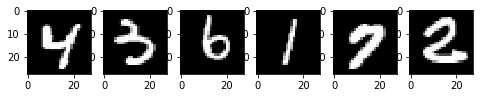

In [4]:
print('Sample input data:')
fig = plt.figure(figsize=(8, 8))
row = 1
col = 6
pos = 1
for idx in random.sample(range(1, 60000), 6):
  img = np.array(trainset[idx][0]).reshape(28, 28)
  fig.add_subplot(row, col, pos)
  pos += 1
  plt.imshow(img, cmap='gist_gray', interpolation='nearest')
plt.show()

In [5]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [6]:
net = Model()
lr = 0.01

# loss function
criterion = torch.nn.CrossEntropyLoss()
print(criterion)

# optimizer
optimizer = torch.optim.SGD(net.parameters(), lr = lr)
print(optimizer)

CrossEntropyLoss()
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [7]:
# Define your training Loop
def train_epoch(model, dataloader, criterion, optimizer):
  model = model.float()
  model.train()
  epoch_loss = 0
  correct = 0.
  samples = 0.
  for sample in dataloader:
    optimizer.zero_grad()
    data, label = sample
    prediction = model(data)
    loss = criterion(prediction, label)
    correct += sum(torch.argmax(prediction, dim=1) == label)
    samples += len(data)
    epoch_loss += loss.data
    loss.backward()
    optimizer.step()
  return epoch_loss, correct/samples

def test_epoch(model, dataloader, criterion):
    model.eval()
    epoch_loss = 0
    correct = 0.
    samples = 0.
    for sample in dataloader:
        data, label = sample
        prediction = model(data)
        loss = criterion(prediction, label)
        correct += sum(torch.argmax(prediction, dim=1) == label)
        samples += len(data)
        epoch_loss += loss.data
    return epoch_loss, correct/samples

In [ ]:
train_loss, train_accuracy = [], []
test_loss, test_accuracy = [], []

for i in tqdm.tnrange(100):
    loss, accuracy = train_epoch(net, trainloader, criterion, optimizer)
    train_loss.append(loss)
    train_accuracy.append(accuracy)
    loss, accuracy = test_epoch(net, testloader, criterion)
    test_loss.append(loss)
    test_accuracy.append(accuracy)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:

def plot(train_acc, train_loss, test_acc, test_loss, epochs):
  fig, axes = plt.subplots(1, 2, figsize=(10, 3))
  plt.sca(axes[0])

  axes[0].set_xlabel('epocs')
  axes[0].set_ylabel('accuracy')

  axes[0].plot(range(1, epochs+1), train_acc, label = "train accuracy")
  axes[0].plot(range(1, epochs+1), test_acc, label = "val accuracy")
               
  axes[0].legend()

  plt.sca(axes[1])
  axes[1].set_xlabel('epocs')
  axes[1].set_ylabel('Loss')

  axes[1].plot(range(1, epochs+1), train_loss, label = "train loss")
  axes[1].plot(range(1, epochs+1), test_loss, label = "val loss")
  axes[1].legend()
  plt.show()

# plot graph before normalization
plot(train_accuracy, train_loss, test_accuracy, test_loss, 100)